In [3]:
from collections import Counter
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

wkdir = r"../../"

In [4]:
# Read data.
inventor_df = pd.read_pickle(wkdir+r"data/inProcess/raw_inventor_df.pkl")
patent_df = pd.read_pickle(wkdir+r"data/inProcess/patent_all_corp.pkl")

This page applies the linear model proposed in Bonhomme's team paper.

The model specification is 
$$ y = \mu_n + \lambda_n ( \alpha_1 + \cdots + \alpha_n ) + \varepsilon. $$

That is, team output $y$ is determined by a linear function of the aggregate individual ability $\alpha_i$. Here, the linear function of the team can be heterogeneous (in team sizes here, but I think this can be easily generalized to other team characteristics).

The model is based on the following assumptions:
- Individual abilities are linearly combined.
- Individual ability is constant over time.
- Firm characteristics do not contribute into team output.
- Team formation is independent of team-specific shocks. (Assumption 1 in their paper)
- Team shocks to a collection of inventors collaborating repeatedly are independent. (Assumption 2)
- Team effects are absent. That is, there is no specialty of a given team. (Assumption 2)

His paper also proposes a nonlinear model to accommodate complementarity between inventors. However, his nonlinear model is far more computationally intensive and his nonlinear model is a random effect model which cannot produce estimates of inventor qualities.

The estimation of linear model takes several steps:
1. Determine subsets of identifiable inventors. (Most time-consuming, about 16 hours on the following data sample.)
2. Estimate team effects $\lambda$'s.
3. Estimate inventor fixed effects.

I made several modifications to his original codes to deal with millions of observations. The main modification is to use iterative method to solve large linear systems.

First, I restricted inventors to those with at least five patents following his paper. This greatly reduced data size.

In [5]:
print(f"This reduces the number of inventors from {len(set(inventor_df.inventor_id))} to {len(inventor_df.groupby('inventor_id').size().pipe(lambda df: df[df>=5]))}.")

This reduces the number of inventors from 3864406 to 958584.


In [6]:
patent_df.columns

Index(['patent_id', 'filing_date', 'issue_date', 'assignee_id',
       'assignee_name', 'assignee_city', 'assignee_state', 'assignee_country',
       'cites', 'cites_5yr', 'cites_dfe', 'cites_5yr_dfe', 'cpc_groups',
       'ipc_groups', 'uspc_subclasses', 'inventors_id', 'kpss_xi_real',
       'kpss_xi_nominal', 'kpss_cites', 'kpss_permno', 'aeri_bsim5',
       'aeri_fsim01', 'aeri_fsim25', 'aeri_fsim610', 'aeri_lqsim05',
       'aeri_lqsim010', 'aeri_bk_p90_alqsim05', 'aeri_bk_p90_alqsim010',
       'aeri_fcitALL'],
      dtype='object')

In [7]:
cpc_cites_df = pd.read_table(
    wkdir+r"data/raw/patentsview/g_cpc_current.tsv", 
    dtype={"patent_id": str},
    usecols=["patent_id", "cpc_sequence", "cpc_class"]
).sort_values(
    ["patent_id", "cpc_sequence"]
).assign(
    cpc_rank = lambda df: df.groupby('patent_id').transform('size') - df.cpc_sequence
).groupby(['patent_id', 'cpc_class'])['cpc_rank'].sum().reset_index().assign(
    cpc_weight = lambda df: df.cpc_rank / df.groupby('patent_id')['cpc_rank'].transform('sum')
).merge(
    patent_df[['patent_id', 'cites', 'filing_date']].assign(
        filing_year = lambda df: df.filing_date.apply(lambda x: int(x[:4]))
    ), on='patent_id'
).assign(
    cites_weighted = lambda df: df.cites * df.cpc_weight,
    avg_cites = lambda df: df.groupby(['cpc_class', 'filing_year'])['cites_weighted'].transform('sum') / df.groupby(['cpc_class', 'filing_year'])['cpc_weight'].transform('sum'),
    cites_adj_weighted = lambda df: ( 1 + df.cites ) / ( 1 + df.avg_cites ) * df.cpc_weight,
).groupby('patent_id')['cites_adj_weighted'].sum().rename('cites_adj').reset_index()

In [8]:
patent_df = patent_df.merge(
    cpc_cites_df, on='patent_id'
)

In [9]:
var = "cites_adj"

In [10]:
inventor_patent_df = inventor_df.merge(
    patent_df[["patent_id", "assignee_id", "filing_date", var]],
    on="patent_id", how="inner"
)
subsample_df = inventor_patent_df.merge(
    inventor_patent_df.groupby("inventor_id").size().pipe(lambda ser: ser[ser>=5]).rename("count").reset_index(),
    on="inventor_id", how="inner"
)[["patent_id", "inventor_id", var]].assign(
    pat_id = lambda df: df.groupby("patent_id").ngroup()+1,
    inv_id = lambda df: df.groupby("inventor_id").ngroup()+1
)

In [11]:
print(f"This subsample has {len(subsample_df)} observations, {len(set(subsample_df.patent_id))} patents and {len(set(subsample_df.inventor_id))} inventors.")

This subsample has 12898447 observations, 5601149 patents and 814543 inventors.


In [12]:
subsample_df[["pat_id", "inv_id", var]].to_csv(
    wkdir+r"/code/honghao/Codes_Inventors/data.txt", sep=' ', header=False, index=False
)

Give the proportions of each group and consider larger groups.

Team size effects are estimated as follows. (Assume $\mu_n=0$)
|$n$|1|2|3|$\ge4$|
|---|---|---|---|---|
|$\lambda_n$|1.0000|0.5394|0.3797|0.2727|

Fixed effects are estimated as follows.

In [13]:
estimates_df = pd.read_csv(wkdir+r"/code/honghao/Codes_Inventors/est.txt", dtype={"inv_id": 'int64'})
estimates_df.columns = ["inv_id", "inventor_fixed_effects"]

In [14]:
estimates_df

,inv_id,inventor_fixed_effects
0,1,-7.001061
1,2,0.345440
2,3,-2.210115
3,4,1.424866
4,5,3.014006
...,...,...
795181,814539,0.204587
795182,814540,0.673622
795183,814541,1.034075
795184,814542,0.273024


In [15]:
print(f"Of {len(set(subsample_df.inventor_id))} inventors, {len(estimates_df)/len(set(subsample_df.inventor_id)):.2%} are identified.")

Of 814543 inventors, 97.62% are identified.


In [16]:
inventor_firm_panel_df = subsample_df.merge(estimates_df, on='inv_id').merge(
    pd.read_csv(
        wkdir+r"data/raw/kpss/KPSS_2020_public.csv",
        dtype={"patent_num": str},
        usecols=["patent_num", "permno", "issue_date"]
    ).rename({
        "patent_num": "patent_id"
    }, axis=1), on='patent_id'
).assign(
    year = lambda df: df.issue_date.apply(lambda x: int(x[-4:]))
).drop_duplicates(["permno", "inventor_id", "year"]).merge(
    pd.read_csv(wkdir+r"data/raw/ccm/ccm_sale_xrd_ev.csv").rename(
            columns={'LPERMNO': 'permno'}
    )[['permno', 'sale', 'xrd', 'che', 'lt', 'prcc_c', 'csho', 'datadate']].assign(
        year = lambda df: df.datadate.apply(lambda x: int(x[:4])),
        ev = lambda df: df["prcc_c"] * df["csho"] + df["lt"] - df["che"]
    ).drop_duplicates(['permno', 'year']), 
    on=['permno', 'year']
)

In [17]:
inventor_firm_panel_df

,patent_id,inventor_id,cites_adj,pat_id,inv_id,inventor_fixed_effects,permno,issue_date,year,sale,xrd,che,lt,prcc_c,csho,datadate,ev
0,10000000,fl:jo_ln:marron-5,1.928462,1,336793,1.414955,24942,06/19/2018,2018,27058.000,841.000,3608.000,19981.000,153.35,282.100,2018-12-31,59633.03500
1,10000642,fl:jo_ln:wahl-1,0.480122,486,348791,-0.540497,24942,06/19/2018,2018,27058.000,841.000,3608.000,19981.000,153.35,282.100,2018-12-31,59633.03500
2,10000642,fl:ri_ln:gentilman-1,0.480122,486,577594,0.940555,24942,06/19/2018,2018,27058.000,841.000,3608.000,19981.000,153.35,282.100,2018-12-31,59633.03500
3,10000642,fl:ch_ln:nordahl-1,0.480122,486,96041,0.613664,24942,06/19/2018,2018,27058.000,841.000,3608.000,19981.000,153.35,282.100,2018-12-31,59633.03500
4,10000642,fl:hu_ln:nguyen-43,0.480122,486,263400,3.661327,24942,06/19/2018,2018,27058.000,841.000,3608.000,19981.000,153.35,282.100,2018-12-31,59633.03500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550660,8734560,fl:st_ln:miranda-5,0.795526,4578930,667636,0.676038,25304,05/27/2014,2014,2065.738,6.348,62.843,1905.467,18.89,80.660,2014-12-31,3366.29140
2550661,9926724,fl:jo_ln:kamin-1,0.380898,5542178,332288,0.261045,85903,03/27/2018,2018,118.217,NaN,45.414,16.867,13.61,12.436,2018-12-31,140.70696
2550662,9183215,fl:er_ln:smiling-1,0.161433,4941739,175424,0.161235,13625,11/10/2015,2015,425.149,41.322,288.382,180.556,32.34,35.686,2015-12-31,1046.25924
2550663,9183261,fl:an_ln:rodland-1,0.484300,4941780,35126,0.065630,13625,11/10/2015,2015,425.149,41.322,288.382,180.556,32.34,35.686,2015-12-31,1046.25924


In [18]:
def corr(x, y):
    lst = {}
    # Pearson.
    res = pearsonr(x, y)
    ci = res.confidence_interval()
    lst.update({"pearson_r": res.correlation, "pearson_ci_low": ci.low, "pearson_ci_high": ci.high})
    # Spearman.
    res = spearmanr(x, y)
    r = res.correlation
    zr = np.log((1+r)/(1-r))/2
    zh = 1.96*np.sqrt((1+r*r/2)/(len(x)-3))
    cl = (np.exp(2*(zr-zh))-1)/(np.exp(2*(zr-zh))+1)
    ch = (np.exp(2*(zr+zh))-1)/(np.exp(2*(zr+zh))+1)
    lst.update({"spearman_r": r, "spearman_ci_low": cl, "spearman_ci_high": ch})
    # Kendall tau.
    res = kendalltau(x, y)
    r = res.correlation
    n = len(x)
    zh = 1.96*(2*(2*n + 5))/(9*n*(n - 1))
    lst.update({"kendall_tau_r": r, "kendall_tau_ci_low": r-zh, "kendall_tau_ci_high": r+zh})
    return pd.Series(lst)

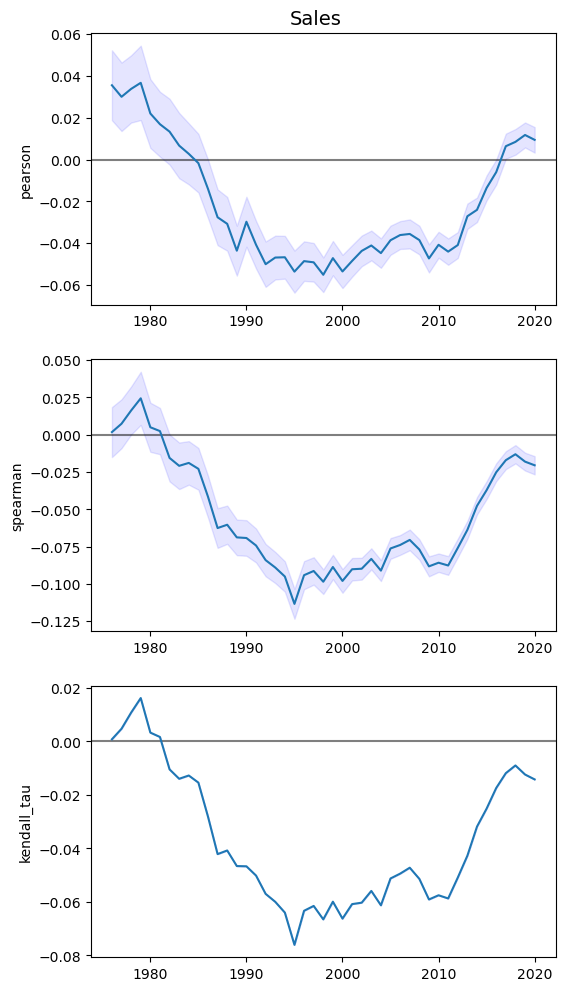

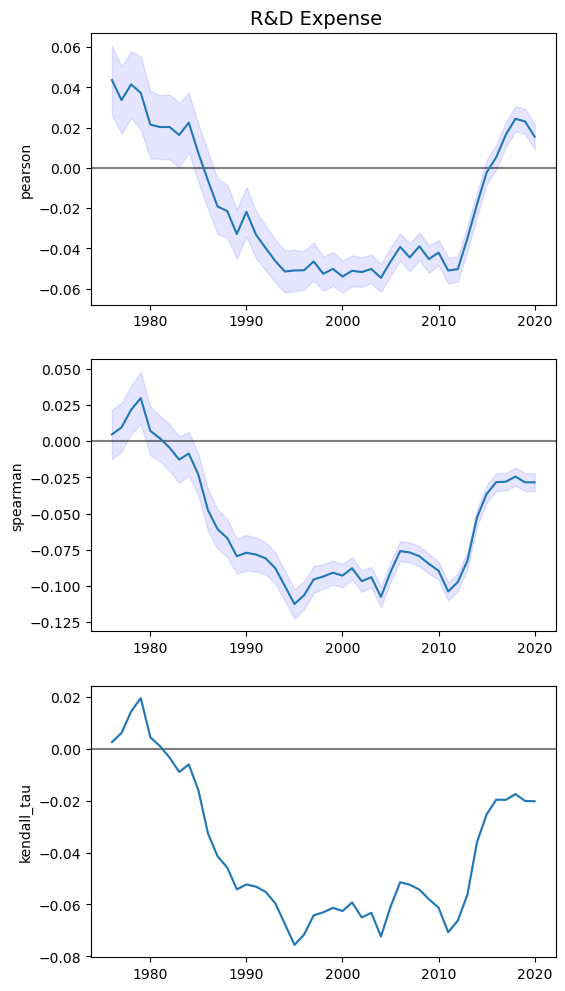

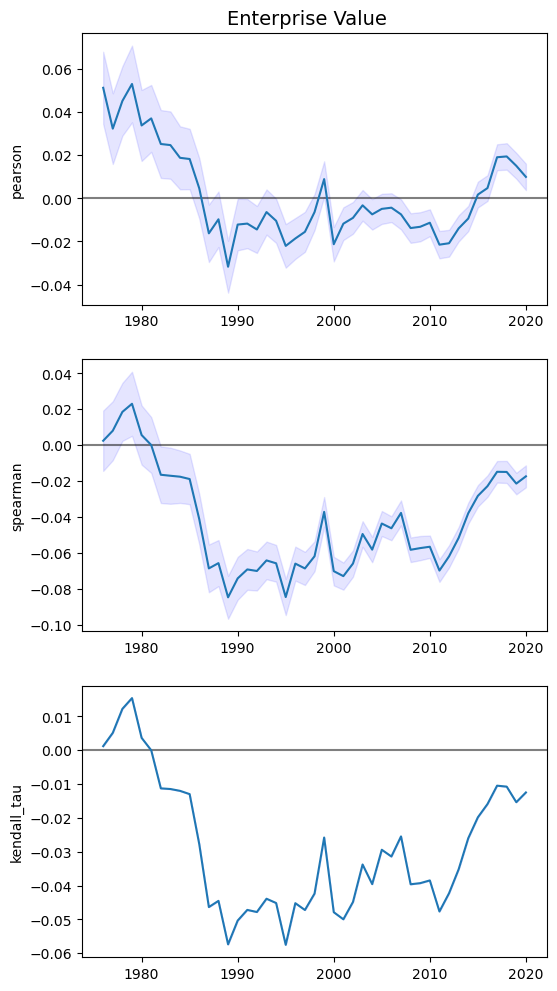

In [19]:
for var, title in [('sale', "Sales"), ('xrd', "R&D Expense"), ('ev', "Enterprise Value")]:
    to_plot = inventor_firm_panel_df[['year',var,'inventor_fixed_effects']].dropna().groupby('year').apply(
        lambda df: corr(df[var], df.inventor_fixed_effects)
    ).reset_index()
    fig, axes = plt.subplots(3, 1, figsize=(6,12))
    fig.suptitle(title, fontsize=14, y=0.9)
    for meth, ax in zip(["pearson", "spearman", "kendall_tau"], axes):
        ax.axhline(y=0, color='black', alpha=.5)
        ax.plot(to_plot['year'], to_plot[f"{meth}_r"])
        ax.fill_between(to_plot['year'], to_plot[f"{meth}_ci_low"], to_plot[f"{meth}_ci_high"], color='b', alpha=.1)
        ax.set(ylabel=meth)